Solve for homogeneous Poisson problems using FEANet framework 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import h5py
import meshio
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshSquare
from FEANet.model import KNet, FNet
from FEANet.jacobi import JacobiBlockPBC
from Utils import plot

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, n, f = None, size=2.0):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.InstantiateFEANet()
        self.jac = JacobiBlockPBC(self.grid, self.Knet, self.omega)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)

        if(f is None):
            f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = self.fnet(self.jac.pbc_boundary(f)) # due to padding = 1, the output size is n+3 rather than n+1

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, initial_v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = initial_v
        for i in range(num_sweeps_down):
            v = self.jac.jacobi_convolution(v, f)
        return v


In [3]:

# Problem parameters
n = 2**5

x = torch.linspace(-1,1,n+1)
y = torch.linspace(-1,1,n+1)
xx, yy = torch.meshgrid(x, y, indexing='ij')

k = 5.0
l = -4.
m = 3.

rhs = k*torch.sin(l*torch.pi*(xx+0.5))*torch.cos(m*torch.pi*(yy)).reshape((1,1,n+1,n+1))
prob = SingleGrid(n, rhs)

RHS:


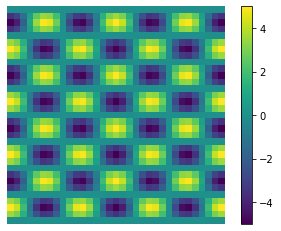

In [4]:
print("RHS:")
plot.plot_field(rhs.detach())

In [5]:
EPS = 5e-6
n_jacobi = 0
u_jacobi = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
u_jacobi_pbc = prob.jac.pbc_boundary(u_jacobi)

residual = prob.f-prob.Knet(u_jacobi_pbc)
u_jacobi = prob.jac.reset_boundary(u_jacobi)
res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
res_jacobi = [res]
print(n_jacobi, res)

while (res > EPS and n_jacobi < 2000):
    u_jacobi = prob.Relax(u_jacobi, prob.f, 1)
    u_jacobi_pbc = prob.jac.pbc_boundary(u_jacobi)
    residual = prob.f-prob.Knet(u_jacobi_pbc)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_jacobi.append(res)
    n_jacobi += 1
    print(n_jacobi, res)

0 0.27434009313583374
1 0.21556054055690765
2 0.1693749725818634
3 0.13308502733707428
4 0.10457049310207367
5 0.08216542750597
6 0.06456082314252853
7 0.050728149712085724
8 0.039859235286712646
9 0.03131908178329468
10 0.024608712643384933
11 0.019336096942424774
12 0.015193185769021511
13 0.011937922798097134
14 0.009380128234624863
15 0.0073703620582818985
16 0.00579120684415102
17 0.004550390876829624
18 0.0035754332784563303
19 0.0028093643486499786
20 0.002207443118095398
21 0.0017344796797260642
22 0.0013628506567329168
23 0.001070850994437933
24 0.0008414099575020373
25 0.0006611300632357597
26 0.0005194767727516592
27 0.0004081769147887826
28 0.00032071961322799325
29 0.00025200637173838913
30 0.0001980090164579451
31 0.00015558532322756946
32 0.00012224809324834496
33 9.605195373296738e-05
34 7.547823042841628e-05
35 5.93060722167138e-05
36 4.6596687752753496e-05
37 3.6613586416933686e-05
38 2.876753751479555e-05
39 2.260674773424398e-05
40 1.7762178686098196e-05
41 1.395610

Solution converges after  46 Weighted Jacobi iterations
Solution:


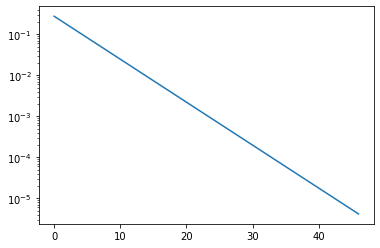

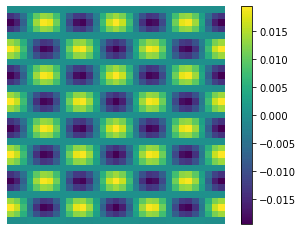

In [6]:
print("Solution converges after ", n_jacobi, "Weighted Jacobi iterations")

plt.plot(res_jacobi)
plt.yscale('log')

print("Solution:")
plot.plot_field(u_jacobi.detach())
